In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import os.path

# google sheets
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

### Altenticação do google e captura de dados

In [14]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# Aqui deve ser colocado o ID da planilha que voce pode encontrar na URL da planilha
SAMPLE_SPREADSHEET_ID = '1uIDmfUZqkbaLZJUOZzOu0nsU_PT8kpYvKP6L9z0vDRk'
# Aqui deve ser colocado o nome da aba que voce quer ler seguindo o padrao: 'Nome da Aba'!A1:B2
SAMPLE_RANGE_NAME = 'Folha2!A2:C1000'

creds = None
df = None
    
# verifica se o token.json existe
if os.path.exists('../env/token.json'):
    # Carrega as credenciais
    creds = Credentials.from_authorized_user_file('../env/token.json', SCOPES)
else:
    print('Redirecionando para autenticação...')
    
# Se nao existir o token.json, faz o login
if not creds or not creds.valid:
    # Se as credenciais expiraram, faz o refresh
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            '../env/credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('../env/token.json', 'w') as token:
        token.write(creds.to_json())
        
try:
    service = build('sheets', 'v4', credentials=creds)

    # Chama a API do Google Sheets
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    df = pd.DataFrame(values, columns=['Nome', 'Presenca', 'Data'])
    
    # fazer download da planilha e salvar no diretório data
    with open('../data/presenca_ensaio_varoes.csv', 'w') as f:
        f.write(df.to_csv(index=False))
          
    print('Planilha lida com sucesso!')

except HttpError as err:
    print(err)


Planilha lida com sucesso!


In [15]:
len(df)

173

In [16]:
# Convertendo a coluna 'data' para o formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y', errors='coerce').dt.date


In [17]:
# Mapeando 'P' para 1 e 'F' para 0 na coluna 'presenca'
df['Presenca'] = df['Presenca'].apply(lambda x: 1 if x == 'P' else 0)

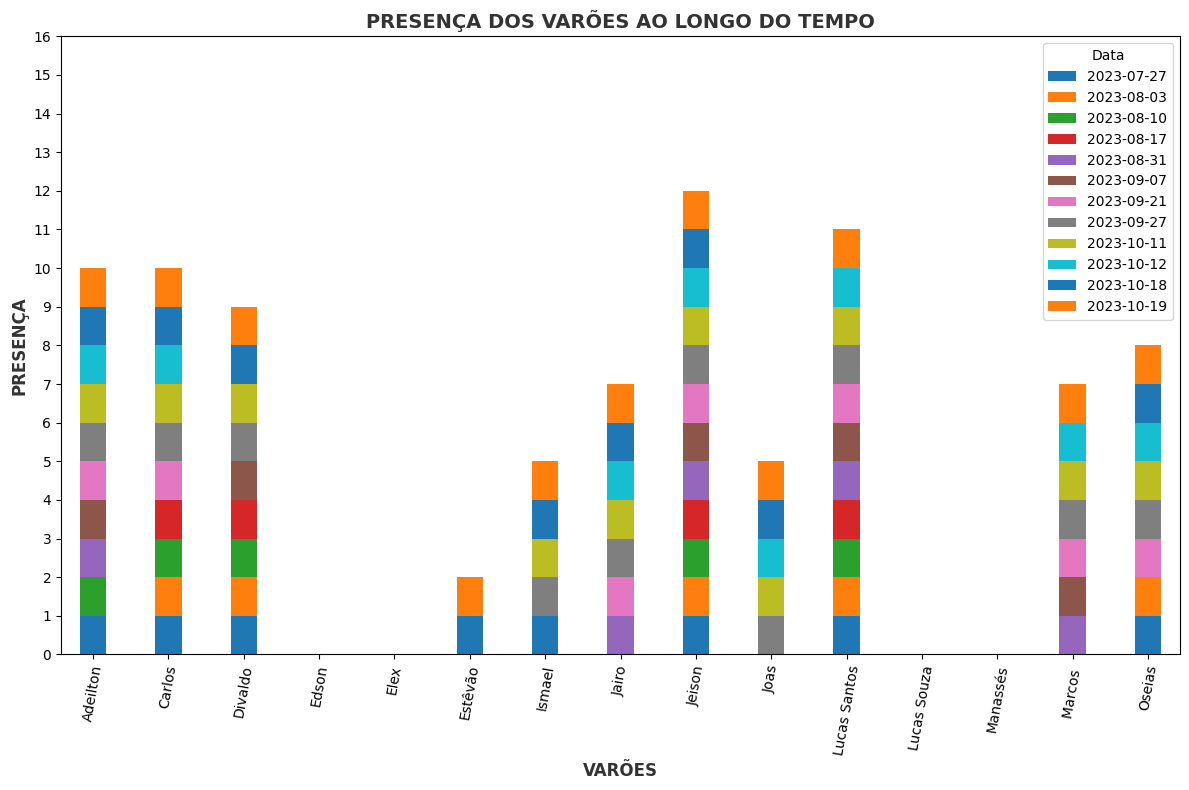

In [18]:
# Criando uma tabela pivô com os nomes como índices e as datas como colunas
pivot_table = df.pivot_table(index='Nome', columns='Data', values='Presenca', aggfunc='first')

# Criando um gráfico de barras empilhadas com cores representando a presença
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), width=0.35)
plt.title('Presença dos varões ao longo do tempo'.upper(), fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('Varões'.upper(), fontsize=12, fontweight='bold', color='#333333', position=(1, 1), rotation=0)
plt.ylabel('Presença'.upper(), fontsize=12, fontweight='bold', color='#333333', position=(1, 1))
plt.yticks(range(0, len(df['Data'].unique())+5))  # Definindo os valores inteiros no eixo Y
plt.xticks(rotation=80)
plt.tight_layout()

# Salvar imagem
plt.savefig('../img/reports/relatorio_img.png');

# Exibindo o gráfico
plt.show();